In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
import tensorflow as tf


In [3]:
# load data
dataframe = pd.read_csv('/content/drive/MyDrive/short_csv_latest_11-10-21.csv', sep = r',',skipinitialspace=True)

In [4]:
dataframe=dataframe.dropna(axis=1,how="any")
dataframe=dataframe.drop(columns=['Circuit Name'])
dataframe.astype(float)
pd.options.display.float_format = '{:.1f}'.format
dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
dataframe.fillna('mean', inplace=True)

In [5]:
arr=np.array(dataframe.values)
X=arr[0:,1:604]
X=X.astype('float')
Y=(arr[0:,603]).astype('float')

In [6]:
# Scaling the data to make it suitable for the auto-encoder
X_scaled = MinMaxScaler().fit_transform(X)
X_normal_scaled = X_scaled[Y == 0]
X_fraud_scaled = X_scaled[Y == 1]


In [7]:
# from sklearn.decomposition import PCA

# # Apply PCA with 250 components
# pca = PCA(n_components=250)
# X_scaled_pca = pca.fit_transform(X_scaled)

# print("Original data shape:", X_scaled.shape)
# print("PCA transformed data shape:", X_scaled_pca.shape)

TRY WITH DIFFERENT FEATURES

In [16]:
from sklearn.decomposition import PCA

# Apply PCA with 250 components
pca = PCA(n_components=250)
X_scaled_pca = pca.fit_transform(X_scaled)

print("Original data shape:", X_scaled.shape)
print("PCA transformed data shape:", X_scaled_pca.shape)

Original data shape: (478, 603)
PCA transformed data shape: (478, 250)


In [17]:
from sklearn.model_selection import train_test_split

# Split the scaled data with PCA into training and testing sets
X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_scaled_pca, Y, test_size=0.2, random_state=42)

print("Shape of training data (X_train_pca):", X_train_pca.shape)
print("Shape of testing data (X_test_pca):", X_test_pca.shape)
print("Shape of training labels (Y_train):", Y_train.shape)
print("Shape of testing labels (Y_test):", Y_test.shape)

Shape of training data (X_train_pca): (382, 250)
Shape of testing data (X_test_pca): (96, 250)
Shape of training labels (Y_train): (382,)
Shape of testing labels (Y_test): (96,)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Random Forest Classifier using PCA-transformed data
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier_pca.fit(X_train_pca, Y_train)

# Make predictions on the PCA-transformed test data
y_pred_pca_rf = rf_classifier_pca.predict(X_test_pca)

# Evaluate the model
print("Random Forest Classifier Results on PCA-Transformed Data:")
print("Accuracy:", accuracy_score(Y_test, y_pred_pca_rf))
print("Classification Report:\n", classification_report(Y_test, y_pred_pca_rf))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred_pca_rf))

Random Forest Classifier Results on PCA-Transformed Data:
Accuracy: 0.9895833333333334
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        14
         1.0       1.00      0.99      0.99        82

    accuracy                           0.99        96
   macro avg       0.97      0.99      0.98        96
weighted avg       0.99      0.99      0.99        96

Confusion Matrix:
 [[14  0]
 [ 1 81]]


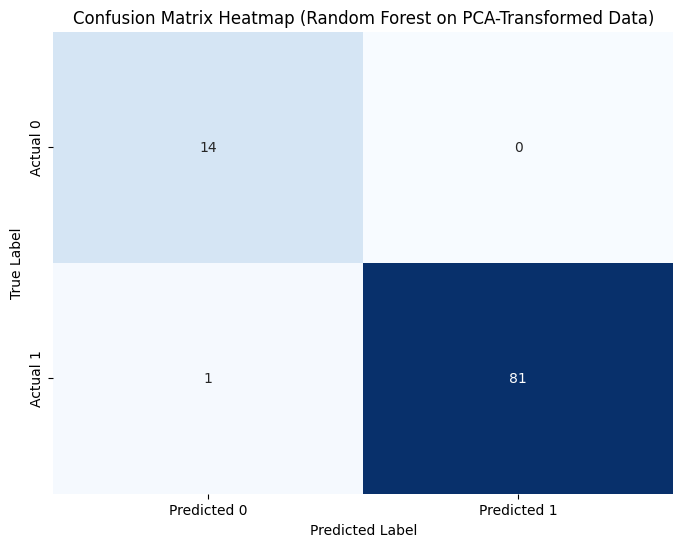

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and display the confusion matrix as a heatmap
cm_pca_rf = confusion_matrix(Y_test, y_pred_pca_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap (Random Forest on PCA-Transformed Data)')
plt.show()

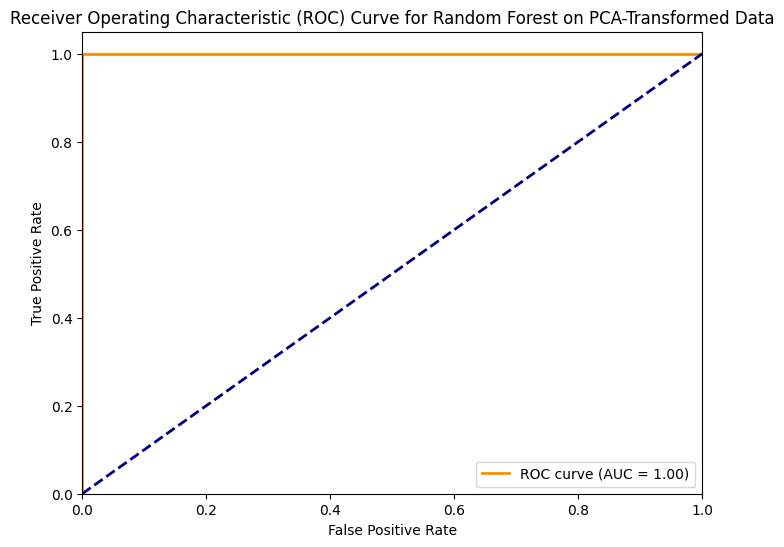

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities of the positive class
y_pred_proba_pca_rf = rf_classifier_pca.predict_proba(X_test_pca)[:, 1]

# Calculate the ROC curve
fpr_pca_rf, tpr_pca_rf, thresholds_pca_rf = roc_curve(Y_test, y_pred_proba_pca_rf)

# Calculate the AUC
roc_auc_pca_rf = auc(fpr_pca_rf, tpr_pca_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca_rf, tpr_pca_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_pca_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest on PCA-Transformed Data')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Train Logistic Regression on PCA-transformed data
log_reg_pca = LogisticRegression(random_state=42)
log_reg_pca.fit(X_train_pca, Y_train)

# Train SVM on PCA-transformed data
svm_pca = SVC(probability=True, random_state=42) # probability=True is needed for VotingClassifier with soft voting
svm_pca.fit(X_train_pca, Y_train)

# Create an ensemble model using VotingClassifier
# Using 'soft' voting to consider predicted probabilities
ensemble_clf = VotingClassifier(estimators=[('rf', rf_classifier_pca), ('lr', log_reg_pca), ('svm', svm_pca)], voting='soft')

# Train the ensemble model
ensemble_clf.fit(X_train_pca, Y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_clf.predict(X_test_pca)

# Evaluate the ensemble model
print("Ensemble Model Results on PCA-Transformed Data:")
print("Accuracy:", accuracy_score(Y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(Y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred_ensemble))

Ensemble Model Results on PCA-Transformed Data:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        82

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Confusion Matrix:
 [[14  0]
 [ 0 82]]


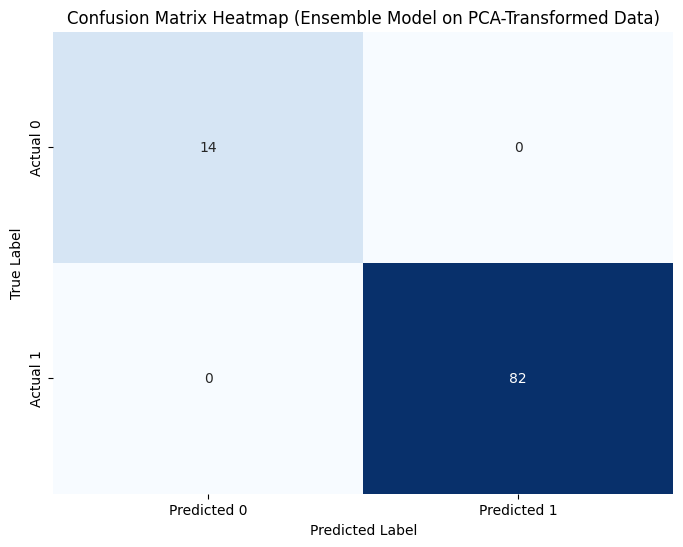

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate and display the confusion matrix as a heatmap for the ensemble model
cm_ensemble = confusion_matrix(Y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap (Ensemble Model on PCA-Transformed Data)')
plt.show()

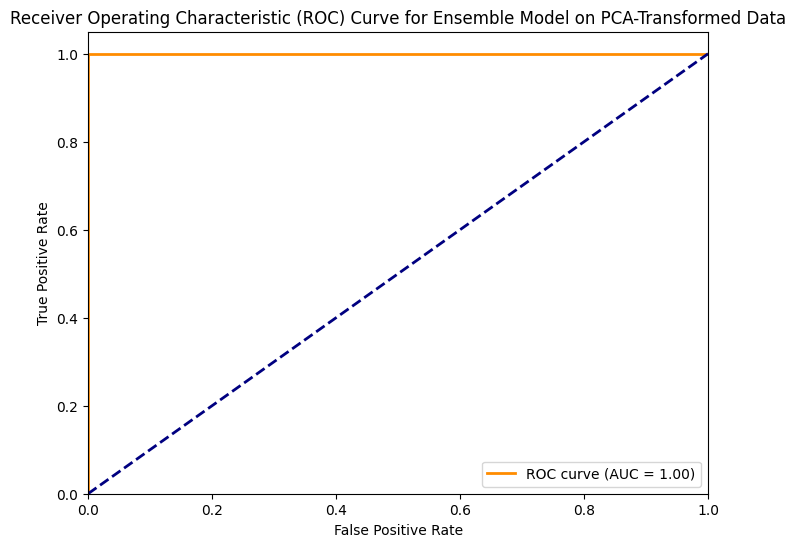

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities of the positive class for the ensemble model
# Note: ensemble_clf.predict_proba returns probabilities for each class
y_pred_proba_ensemble = ensemble_clf.predict_proba(X_test_pca)[:, 1]

# Calculate the ROC curve for the ensemble model
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(Y_test, y_pred_proba_ensemble)

# Calculate the AUC for the ensemble model
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

# Plot the ROC curve for the ensemble model
plt.figure(figsize=(8, 6))
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble Model on PCA-Transformed Data')
plt.legend(loc="lower right")
plt.show()